In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import time
from scipy import stats

from ParallelSolve import gurobi_network_first_stage, majority_vote_network, gurobi_second_stage_wSol, sequentialEvaluate
from multiprocessing import Queue, Process

In [2]:
# temporarily use the same pareto distribution for all demands and another pareto distribution for all supplies
def genPareto(n, rng, paretoShape):
    return stats.lomax.rvs(paretoShape, size=n, random_state=rng) + 1

In [3]:
def gurobi_second_stage(sample_S, sample_D, x, C, Q_sp, Q_pc, R, M, H):
    # second stage LP problem
    s, p, g = Q_sp.shape
    c, g, n = sample_D.shape
    model = Model("second_stage")
    model.setParam(GRB.Param.OutputFlag, 0)
    y_sp = model.addVars(s, p, g, n, lb=0, vtype=GRB.CONTINUOUS, name="y_sp")
    y_pc = model.addVars(p, c, g, n, lb=0, vtype=GRB.CONTINUOUS, name="y_pc")
    z = model.addVars(c, g, n, lb=0, vtype=GRB.CONTINUOUS, name="z")

    obj_expr = 1/n * quicksum(Q_sp[i, j, l] * y_sp[i, j, l, a] for i in range(s) for j in range(p) for l in range(g) for a in range(n))\
                        + 1/n * quicksum(Q_pc[j, i, l] * y_pc[j, i, l, a] for j in range(p) for i in range(c) for l in range(g) for a in range(n))\
                            + 1/n * quicksum(H[i, l] * z[i, l, a] for i in range(c) for l in range(g) for a in range(n))
    
    model.setObjective(obj_expr, GRB.MINIMIZE)

    model.addConstrs((quicksum(y_sp[i, j, l, a] for i in range(s)) - quicksum(y_pc[j, i, l, a] for i in range(c)) == 0
                        for a in range(n) for l in range(g) for j in range(p)), name="flow")
    
    model.addConstrs((quicksum(y_pc[j, i, l, a] + z[i, l, a] for j in range(p)) >= sample_D[i, l, a]
                        for a in range(n) for l in range(g) for i in range(c)), name="demand")
    
    model.addConstrs((quicksum(y_sp[i, j, l, a] for j in range(p)) <= sample_S[i, l, a]
                        for a in range(n) for l in range(g) for i in range(s)), name="supply")
    
    model.addConstrs((quicksum(R[j, l] * quicksum(y_sp[i, j, l, a] for i in range(s)) for l in range(g)) <= M[j] * x[j]
                        for a in range(n) for j in range(p)), name="capacity")
    
    model.setParam("Threads", 8)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.ObjVal + sum(C[j] * x[j] for j in range(p)) 
    else:
        print("No optimal solution found.")
        return None

In [4]:
# functions that implements the comparison between SAA and Bagging-SAA, as well as evaluating the results
def comparison_final(B_list,k_list,number_of_iterations,sample_number,rng, sample_args, *prob_args):
    # a unified function that compare SAA with different configurations of Bagging
    # prob_args: parameters, including C, Q_sp, Q_pc, R, M, H
    # sample_args['params'] has dimension two for the two pareto distributions
    # sample_args['size'] shows the form of the sample
    s, c, g  = sample_args['size']
    SAA_list = []
    bagging_list = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))] 
    for n in sample_number:
        SAA_intermediate = []
        bagging_intermediate = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))]
        for _ in range(number_of_iterations):
            tic = time.time()
            ####### places that need to change for different problems
            sample_S = genPareto((s,g,n), rng, sample_args['params'][0])
            sample_D = genPareto((c,g,n), rng, sample_args['params'][1])

            SAA = majority_vote_network(sample_S, sample_D, 1, n, gurobi_network_first_stage, rng, *prob_args)
            #######
            SAA = round(SAA) if type(SAA) == int or type(SAA) == float else tuple([round(x) for x in SAA])
            SAA_intermediate.append(SAA)
            print(f"Sample size {n}, iteration {_}, SAA time: {time.time()-tic}")

            for ind1, B in enumerate(B_list):
                for ind2, k in enumerate(k_list):
                    tic = time.time()
                    ####### places that need to change for different problems
                    if k < 1:
                        bagging = majority_vote_network(sample_S, sample_D, B, int(n*k), gurobi_network_first_stage, rng, *prob_args)
                    else:
                        bagging = majority_vote_network(sample_S, sample_D, B, k, gurobi_network_first_stage, rng, *prob_args)
                    #######
                    bagging = round(bagging) if type(bagging) == int or type(bagging) == float else tuple([round(x) for x in bagging])
                    bagging_intermediate[ind1][ind2].append(bagging)
                    print(f"Sample size {n}, iteration {_}, B={B}, k={k}, Bagging time: {time.time()-tic}")
            
        SAA_list.append(SAA_intermediate)
        for ind1 in range(len(B_list)):
            for ind2 in range(len(k_list)):
                bagging_list[ind1][ind2].append(bagging_intermediate[ind1][ind2])
    
    # SAA_list dimension: len(sample_number) * len(number_of_iterations) * len(SAA)
    return SAA_list, bagging_list

        
def evaluation_final(SAA_list, bagging_list, large_number_sample, rng, sample_args, *prob_args):
    s, c, g  = sample_args['size']
    sample_number_len = len(SAA_list)
    number_of_iterations = len(SAA_list[0])
    B_list_len, k_list_len = len(bagging_list), len(bagging_list[0])
    all_solutions = set()
    for i in range(sample_number_len):
        for j in range(number_of_iterations):
            all_solutions.add(tuple(SAA_list[i][j]))
            for ind1 in range(B_list_len):
                for ind2 in range(k_list_len):
                    all_solutions.add(tuple(bagging_list[ind1][ind2][i][j]))
    
    solution_obj_values = {str(tuple(solution)): 0 for solution in all_solutions}

    for solution in all_solutions:
        tic = time.time()
        print(f"Start evaluating solution {solution}")
        sample_large_S = genPareto((s,g,large_number_sample), rng, sample_args['params'][0])
        sample_large_D = genPareto((c,g,large_number_sample), rng, sample_args['params'][1])
        obj_value = gurobi_second_stage(sample_large_S, sample_large_D, solution, *prob_args)
        solution_obj_values[str(solution)] = obj_value
        print(f"Solution {solution}, evaluation time: {time.time()-tic}")
    
    SAA_obj_list, SAA_obj_avg = [], []
    bagging_obj_list, bagging_obj_avg = [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)], [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)]
    for i in range(sample_number_len):
        current_SAA_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(tuple(SAA_list[i][j]))]
            current_SAA_obj_list.append(SAA_obj)
        SAA_obj_list.append(current_SAA_obj_list)
        SAA_obj_avg.append(np.mean(current_SAA_obj_list))

    for ind1 in range(B_list_len):
        for ind2 in range(k_list_len):
            for i in range(sample_number_len):
                current_bagging_obj_list = []
                for j in range(number_of_iterations):
                    bagging_obj = solution_obj_values[str(tuple(bagging_list[ind1][ind2][i][j]))]
                    current_bagging_obj_list.append(bagging_obj)
                bagging_obj_list[ind1][ind2].append(current_bagging_obj_list)
                bagging_obj_avg[ind1][ind2].append(np.mean(current_bagging_obj_list))
    
    return SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg

        
def plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_avg, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            ax.plot(sample_number, bagging_obj_avg[ind1][ind2], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B_list[ind1]}, k={k_list[ind2]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend()
    fig_name  = "obj_avg_" + str(B_list) + '_' +str(k_list) + ".png"
    plt.savefig(fig_name)
    plt.show()
    return

def plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list):
    number_of_iterations = len(SAA_obj_list[0])
    _, ax = plt.subplots()
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            diff_Bk = []
            for i in range(len(sample_number)):
                diff_Bk.append([bagging_obj_list[ind1][ind2][i][j] - SAA_obj_list[i][j] for j in range(number_of_iterations)])
            
            diff_Bk_mean = np.mean(diff_Bk, axis = 1)
            diff_Bk_std_err = stats.sem(diff_Bk, axis = 1)
            diff_conf_int = 1.96 * diff_Bk_std_err

            ax.plot(sample_number, diff_Bk_mean, marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B}, k={k}')
            ax.fill_between(sample_number, diff_Bk_mean - diff_conf_int, diff_Bk_mean + diff_conf_int, alpha = 0.2)
    
    ax.axhline(0, color='grey', linewidth=2, linestyle='--') 
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective difference', size = 20)
    ax.legend()
    fig_name  = "obj_CI_" + str(B_list) + '_' + str(k_list) + ".png"
    plt.savefig(fig_name)
    plt.show()
    return

In [5]:
def evaluation_parallel(SAA_list, bagging_list, large_number_sample, eval_time, rng, sample_args, *prob_args):
    s, c, g  = sample_args['size']
    sample_number_len = len(SAA_list)
    number_of_iterations = len(SAA_list[0])
    B_list_len, k_list_len = len(bagging_list), len(bagging_list[0])
    all_solutions = set()
    for i in range(sample_number_len):
        for j in range(number_of_iterations):
            all_solutions.add(tuple(SAA_list[i][j]))
            for ind1 in range(B_list_len):
                for ind2 in range(k_list_len):
                    all_solutions.add(tuple(bagging_list[ind1][ind2][i][j]))
    
    solution_obj_values = {str(tuple(solution)): [] for solution in all_solutions}

    ###### parallel evaluation ######
    numProcesses = 1
    taskLists = [[] for _ in range(numProcesses)]
    processIndex = 0
    for solution in all_solutions:
        for i in range(eval_time):
            ######## places that need to change for different problems ########
            sample_large = (genPareto((s,g,large_number_sample), rng, sample_args['params'][0]), genPareto((c,g,large_number_sample), rng, sample_args['params'][1]))
            ########
            taskLists[processIndex].append((sample_large, solution))
            processIndex = (processIndex + 1) % numProcesses
    
    processList: list[Process] = []
    queue = Queue()
    for i in range(numProcesses):
        if len(taskLists[i]) > 0:
            ######## places that need to change for different problems ########
            processList.append(Process(target = sequentialEvaluate, args = (gurobi_second_stage_wSol, queue, taskLists[i], *prob_args), daemon=True))
            ########

    for process in processList:
        process.start()
    
    for _ in range(len(all_solutions) * eval_time):
        obj_value, solution = queue.get()
        if solution is not None:
            solution_obj_values[str(solution)].append(obj_value)
    
    for process in processList:
        process.join() 
    
    solution_obj_values = {key: np.mean(value) for key, value in solution_obj_values.items()}
    ###### end of parallel evaluation ######

    SAA_obj_list, SAA_obj_avg = [], []
    bagging_obj_list, bagging_obj_avg = [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)], [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)]
    for i in range(sample_number_len):
        current_SAA_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(tuple(SAA_list[i][j]))]
            current_SAA_obj_list.append(SAA_obj)
        SAA_obj_list.append(current_SAA_obj_list)
        SAA_obj_avg.append(np.mean(current_SAA_obj_list))

    for ind1 in range(B_list_len):
        for ind2 in range(k_list_len):
            for i in range(sample_number_len):
                current_bagging_obj_list = []
                for j in range(number_of_iterations):
                    bagging_obj = solution_obj_values[str(tuple(bagging_list[ind1][ind2][i][j]))]
                    current_bagging_obj_list.append(bagging_obj)
                bagging_obj_list[ind1][ind2].append(current_bagging_obj_list)
                bagging_obj_avg[ind1][ind2].append(np.mean(current_bagging_obj_list))
    
    return SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg    

In [6]:
s, p, c, g = 3, 2, 3, 5

C = np.array([0.84902017, 0.73141691])
Q_sp = np.array([[[0.33959485, 0.93963167, 0.11099611, 0.29228903, 0.32671781],
                    [0.11183712, 0.68568047, 0.89458674, 0.6290198 , 0.45712153]],
                     [[0.30562386, 0.25141794, 0.52145227, 0.93541722, 0.09209385],
                    [0.32229624, 0.78332703, 0.97653641, 0.18445241, 0.03020424]],
                     [[0.3414426 , 0.45228102, 0.22978903, 0.05338668, 0.24009525],
                    [0.92622445, 0.08852084, 0.84160819, 0.02508719, 0.46203217]]])
Q_pc = np.array([[[0.08967017, 0.08001494, 0.29854161, 0.6979279 , 0.12176636],
                    [0.96381038, 0.1531089 , 0.38302768, 0.61996695, 0.90823239],
                    [0.70189534, 0.39932218, 0.55522219, 0.00271483, 0.89190262]],
                     [[0.00499716, 0.94445126, 0.88466098, 0.5649098 , 0.54066034],
                    [0.35775422, 0.14473548, 0.17228491, 0.64621086, 0.6801251 ],
                    [0.22298374, 0.17262673, 0.42564852, 0.25968014, 0.01474239]]])
R = np.array([[0.75762425, 0.60499893, 0.64820431, 0.86142707, 0.01262116],
                [0.67859456, 0.37513025, 0.86190007, 0.18231789, 0.20731563]])
M = np.array([0.96766421, 0.5369463])
H = np.array([[0.19395032, 0.81790575, 0.78516185, 0.20974165, 0.90638053],
                [0.00704014, 0.96558659, 0.15616022, 0.7461778 , 0.73652027],
                [0.72572877, 0.98864562, 0.39330404, 0.68259888, 0.92669604]])

sample_args = {
    'type': 'pareto',
    'size': (s,c,g),
    'params': [1.90394177, 2.00408536]
}


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, SAA time: 0.30010318756103516
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, B=2, k=0.1, Bagging time: 0.2160179615020752
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, B=2, k=10, Bagging time: 0.26638078689575195
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, B=3, k=0.1, Bagging time: 0.35094404

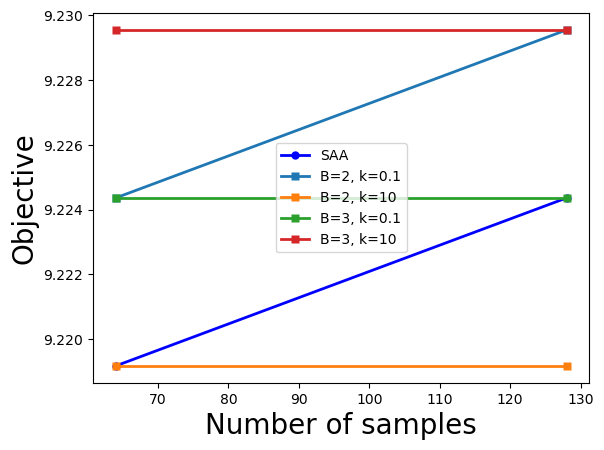

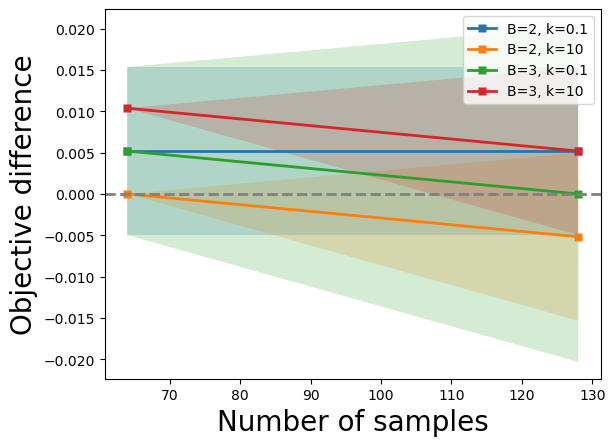

Total time: 4976.65327000618


In [7]:
# previous 93 min
rng = np.random.default_rng(seed=2024)
B_list = [2,3]
k_list = [0.1, 10]
number_of_iterations = 2
sample_number = np.array([2**i for i in range(6, 8)])
large_number_sample = 200000
eval_time = 10

tic = time.time()
SAA_list, bagging_list = comparison_final(B_list, k_list, number_of_iterations, sample_number, rng, sample_args, C, Q_sp, Q_pc, R, M, H)
# SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg = evaluation_final(SAA_list, bagging_list, large_number_sample, rng, sample_args, C, Q_sp, Q_pc, R, M, H)
SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg = evaluation_parallel(SAA_list, bagging_list, large_number_sample, eval_time, rng, sample_args, C, Q_sp, Q_pc, R, M, H)
plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list)
plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list)
print(f"Total time: {time.time()-tic}")

In [6]:
import json
with open("obj_lists.json", 'r') as f:
    results = json.load(f)

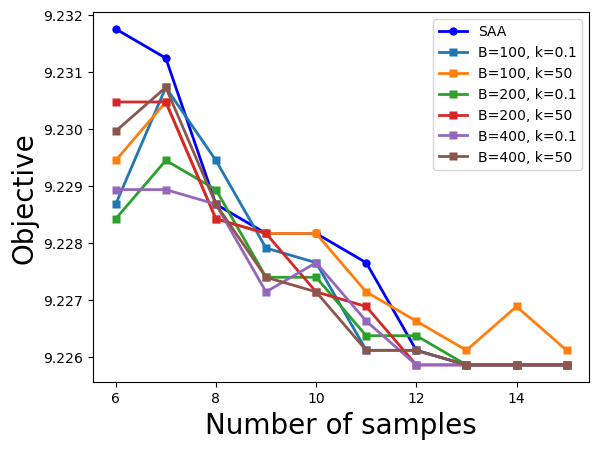

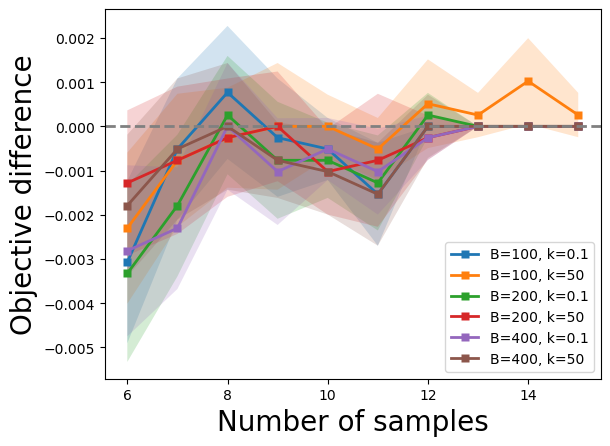

In [9]:
B_list = ['X', 100, 200, 400]
# k_list = [0.05, 0.1, 2, 10, 50]
k_list = ['X', 0.1, 'X', 'X', 50]
sample_number = np.array([2**i for i in range(6, 16)])
sample_number_log = np.log2(sample_number)
plot_final(results['SAA_obj_avg'], results['bagging_obj_avg'], sample_number_log, B_list, k_list)
plot_CI_final(results['SAA_obj_list'], results['bagging_obj_list'], sample_number_log, B_list, k_list)

In [54]:
parameters = {
    'seed': 2024,
    's': s,
    'p': p,
    'c': c,
    'g': g,
    'C': C.tolist(),
    'Q_sp': Q_sp.tolist(),
    'Q_pc': Q_pc.tolist(),
    'R': R.tolist(),
    'M': M.tolist(),
    'H': H.tolist(),
    'sample_args': sample_args,
    'B_list': B_list,
    'k_list': k_list,
    'number_of_iterations': number_of_iterations,
    'sample_number': sample_number.tolist(),
    'large_number_sample': large_number_sample
    }

with open("parameters.json", "w") as f:
    json.dump(parameters, f, indent = 2)